# Task: Generate human faces that don't exist

## Import libraries

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2
from IPython import display
from tqdm import tqdm

## Read Data

Link: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

In [3]:
DATA_PATH = r'D:\tensorflow_tutorial\Gan\data\archive\img_align_celeba\img_align_celeba'
print(f"Total images: {len(os.listdir(DATA_PATH))}")

Total images: 202599


In [4]:
img_names = os.listdir(DATA_PATH)[:100000]

In [46]:
dataset = np.zeros((100000, 160, 160, 1), dtype = 'float32')
i = 0
for img_name in tqdm(img_names[:100000]):
    img_path = os.path.join(DATA_PATH, img_name)
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (160, 160))
    img = np.expand_dims(img, axis=-1)
    img = img.astype('float32')
    img = (img - 127.5) / 127.5
    dataset[i] = img
    i+=1
# dataset = np.array(dataset)
print(dataset.shape)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:11<00:00, 398.28it/s]

(100000, 160, 160, 1)


In [5]:
np.save('dataset_norm_gray_50K.npy', dataset[:50000])
# dataset = np.load('dataset_50k.npy')
# np.save('dataset_norm_100k.npy', dataset)
# np.save('dataset_norm_50k.npy', dataset[:50000])
# np.save('dataset_norm_10k.npy', dataset[:10000])

In [2]:
# dataset = np.load('dataset_norm_100k.npy')
dataset = np.load('dataset_norm_gray_50K.npy')

In [3]:
# Batch and shuffle the data
BUFFER_SIZE = 50000
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## The Generator

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(10*10*256, use_bias=False, input_shape=(400,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((10, 10, 256)))
    assert model.output_shape == (None, 10, 10, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 10, 10, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 20, 20, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 80, 80, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 160, 160, 1)

    return model

Use the (as yet untrained) generator to create an image.

In [5]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25600)             10240000  
                                                                 
 batch_normalization (BatchN  (None, 25600)            102400    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25600)             0         
                                                                 
 reshape (Reshape)           (None, 10, 10, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 128)      5

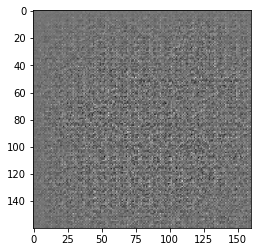

In [6]:
noise = tf.random.normal([1, 400])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## The Discriminator

The discriminator is a CNN-based image classifier.

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[160, 160, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [8]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 80, 80, 64)        0         
                                                                 
 dropout (Dropout)           (None, 80, 80, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 40, 40, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 40, 40, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)      

In [9]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-8.038838e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [13]:
EPOCHS = 50
noise_dim = 400
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [18]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
#   print(predictions[0])
    
  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
#       img = (predictions[i, :, :, :] * 127.5 + 127.5)
#       img = tf.cast(img, tf.uint8)
#       print(img[0])
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch + 61))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real.

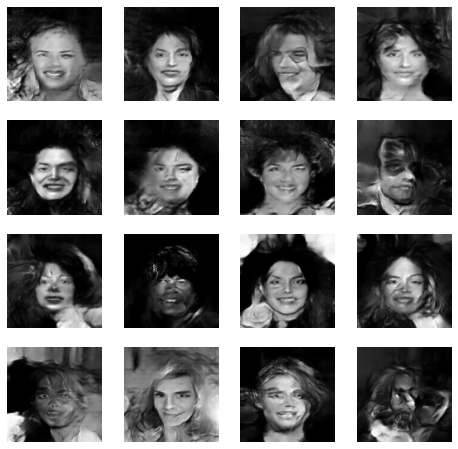

In [19]:
train(train_dataset, 15)

Restore the latest checkpoint.

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [33]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Use `imageio` to create an animated gif using the images saved during training.

In [20]:
anim_file = 'mydcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


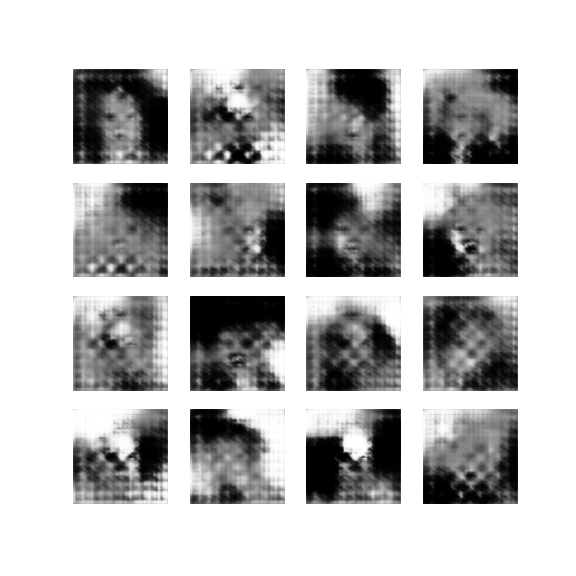

In [21]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Rreferences
1. Code used in this notebook is from https://www.tensorflow.org/tutorials/generative/dcgan
2. Dataset: S. Yang, P. Luo, C. C. Loy, and X. Tang, "From Facial Parts Responses to Face Detection: A Deep Learning Approach", in IEEE International Conference on Computer Vision (ICCV), 2015